#Importing all Dataset

In [41]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

In [42]:
path_to_flight_level_summary = "/content/drive/MyDrive/United Airlines/flight_level_summary.csv"
path_to_flight_passenger_summary = "/content/drive/MyDrive/United Airlines/flight_passenger_summary.csv"
path_to_flight_bag_summary = "/content/drive/MyDrive/United Airlines/flight_bag_summary.csv"

# Calculating Overall Flight Complexity

We combine different aspects of flight operations into a single **overall complexity score** for each flight to identify the most challenging flights.

1. **What we did:**
   - Loaded three datasets: **flight-level**, **passenger-level**, and **bag-level**.
   - Merged them using **5 primary keys** (`company_id`, `flight_number`, `scheduled_departure_date_local`, `scheduled_departure_station_code`, `scheduled_arrival_station_code`) to ensure all data corresponds to the same flight.
   - Filled missing complexity scores with 0 for flights without passenger or bag information.

2. **Why this is necessary:**
   - Each dataset captures a different type of complexity:
     - **Delay complexity** → operational delays and ground time pressures
     - **Passenger complexity** → challenges due to passenger composition
     - **Bag complexity** → baggage handling difficulty
   - Merging ensures we can calculate a **single, unified complexity metric per flight**.

3. **How we calculate overall complexity:**
   - Use a **weighted sum** of the three components:
     - Delay complexity = 25%
     - Passenger complexity = 50%
     - Bag complexity = 25%
   - This produces `overall_flight_complexity`, a score between 0 and 1 (after prior scaling), which can be used for ranking, analysis, and visualization.


In [43]:
# -------------------------------
# Load datasets from your drive
# -------------------------------
# Update paths according to your Google Drive structure
flight_level = pd.read_csv(path_to_flight_level_summary)
passenger_level = pd.read_csv(path_to_flight_passenger_summary)
bag_level = pd.read_csv(path_to_flight_bag_summary)

# -------------------------------
# Merge datasets on 5 primary keys
# -------------------------------
primary_keys = [
    'company_id',
    'flight_number',
    'scheduled_departure_date_local',
    'scheduled_departure_station_code',
    'scheduled_arrival_station_code'
]

# Merge flight + passenger
merged_df = pd.merge(flight_level, passenger_level, on=primary_keys, how='left')

# Merge the above with bag-level
merged_df = pd.merge(merged_df, bag_level, on=primary_keys, how='left')

# -------------------------------
# Fill missing complexity scores with 0 (if any flight has no bag/passenger info)
# -------------------------------
merged_df['passenger_complexity_score'] = merged_df['passenger_complexity_score'].fillna(0)
merged_df['bag_complexity_score'] = merged_df['bag_complexity_score'].fillna(0)
merged_df['delay_complexity_score'] = merged_df['delay_complexity_score'].fillna(0)

# -------------------------------
# Calculate overall flight complexity (adjust weights as desired)
# -------------------------------
weights = {
    'delay_complexity_score': 0.25,
    'passenger_complexity_score': 0.50,
    'bag_complexity_score': 0.25
}

merged_df['overall_flight_complexity'] = (
    merged_df['delay_complexity_score'] * weights['delay_complexity_score'] +
    merged_df['passenger_complexity_score'] * weights['passenger_complexity_score'] +
    merged_df['bag_complexity_score'] * weights['bag_complexity_score']
)


In [44]:
merged_df.head()

,company_id,flight_number,scheduled_departure_date_local,scheduled_departure_station_code,scheduled_arrival_station_code,departure_delay,arrival_delay,flightfly_delay,buffer,ground_time_utilization,...,num_origin_bags,num_transfer_bags,total_bags,transfer_ratio,hot_transfer_ratio,bag_complexity_score,total_bags_score,transfer_ratio_score,hot_transfer_ratio_score,overall_flight_complexity
0,OO,4792,2025-08-04,ORD,ROA,7.0,12.0,19.0,8,0.809524,...,6.0,20.0,42.0,0.476190,0.380952,0.321977,0.089130,0.476190,0.380952,0.162966
1,UA,920,2025-08-03,ORD,LHR,22.0,14.0,36.0,90,0.974468,...,90.0,37.0,143.0,0.258741,0.111888,0.214986,0.308696,0.258741,0.111888,0.146940
2,UA,1776,2025-08-10,ORD,PHL,111.0,111.0,0.0,25,0.907895,...,46.0,38.0,85.0,0.447059,0.011765,0.193606,0.182609,0.447059,0.011765,0.186870
3,OO,5790,2025-08-06,ORD,CRW,105.0,98.0,7.0,194,0.170404,...,14.0,40.0,54.0,0.740741,0.000000,0.256787,0.115217,0.740741,0.000000,0.152702
4,UA,1398,2025-08-05,ORD,ATL,0.0,20.0,24.0,24,0.960000,...,19.0,51.0,70.0,0.728571,0.000000,0.263571,0.150000,0.728571,0.000000,0.162681


Normalizing

In [45]:
# Scale overall complexity 0-1
scaler = MinMaxScaler()
merged_df[['overall_flight_complexity']] = scaler.fit_transform(
    merged_df[['overall_flight_complexity']]
)

In [46]:
# Classify
def classify_complexity(score):
    if score < 0.4:
        return 'Easy'
    elif score < 0.7:
        return 'Medium'
    else:
        return 'Hard'

merged_df['complexity_class'] = merged_df['overall_flight_complexity'].apply(classify_complexity)

# 4️⃣ Check distribution
print(merged_df['complexity_class'].value_counts())


complexity_class
Medium    5215
Easy      2494
Hard       390
Name: count, dtype: int64


1️⃣ Flight Complexity Distribution

Purpose: Show overall flight complexity and the spread of Easy / Medium / Hard flights.

Type: Histogram or violin plot

X-axis: overall_flight_complexity

Y-axis: Count of flights

Color: Class (Easy / Medium / Hard)

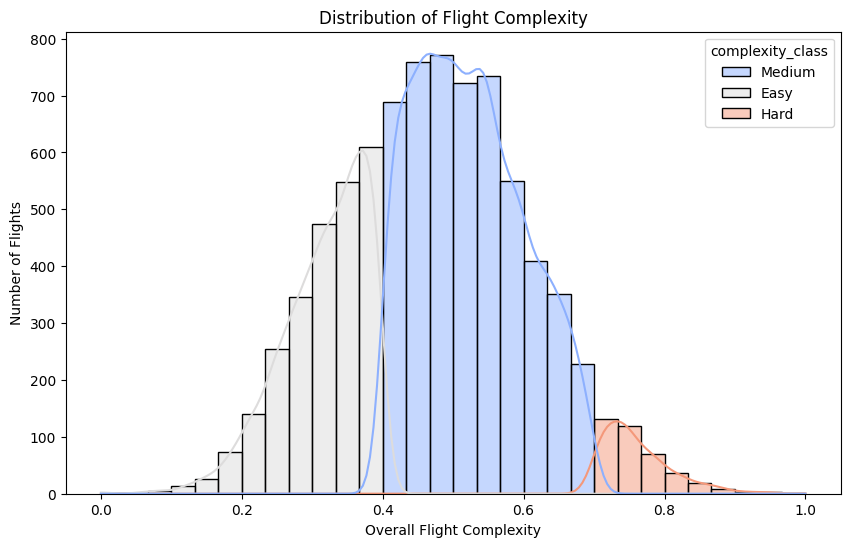

In [47]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
sns.histplot(merged_df, x='overall_flight_complexity', hue='complexity_class', bins=30, palette='coolwarm', kde=True)
plt.title('Distribution of Flight Complexity')
plt.xlabel('Overall Flight Complexity')
plt.ylabel('Number of Flights')
plt.show()

In [48]:
merged_df.columns

Index(['company_id', 'flight_number', 'scheduled_departure_date_local',
       'scheduled_departure_station_code', 'scheduled_arrival_station_code',
       'departure_delay', 'arrival_delay', 'flightfly_delay', 'buffer',
       'ground_time_utilization', 'pressure_on_staff', 'ground_time_deviation',
       'normalized_pressure', 'turnaround_risk', 'route', 'dep_score',
       'arr_score', 'flightfly_score', 'buffer_score', 'pressure_score',
       'ground_dev_score', 'norm_pressure_score', 'turnaround_risk_score',
       'delay_complexity_score', 'total_pax', 'total_lap_children',
       'total_children', 'total_basic_economy', 'total_stroller_users',
       'child_ratio', 'basic_economy_ratio', 'stroller_ratio',
       'total_pax_score', 'child_ratio_score', 'basic_economy_ratio_score',
       'stroller_ratio_score', 'passenger_complexity_score',
       'num_hot_transfer_bags', 'num_origin_bags', 'num_transfer_bags',
       'total_bags', 'transfer_ratio', 'hot_transfer_ratio',
       

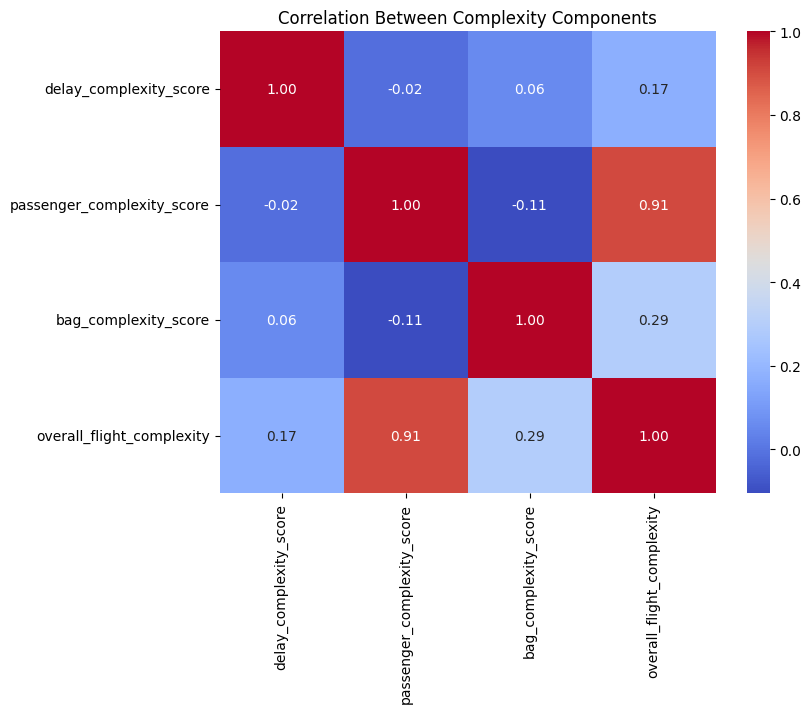

In [49]:
plt.figure(figsize=(8,6))
corr_cols = ['delay_complexity_score', 'passenger_complexity_score', 'bag_complexity_score', 'overall_flight_complexity']
corr_matrix = merged_df[corr_cols].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Between Complexity Components')
plt.show()


In [50]:
merged_df.to_csv('overall_complexity.csv', index=False)

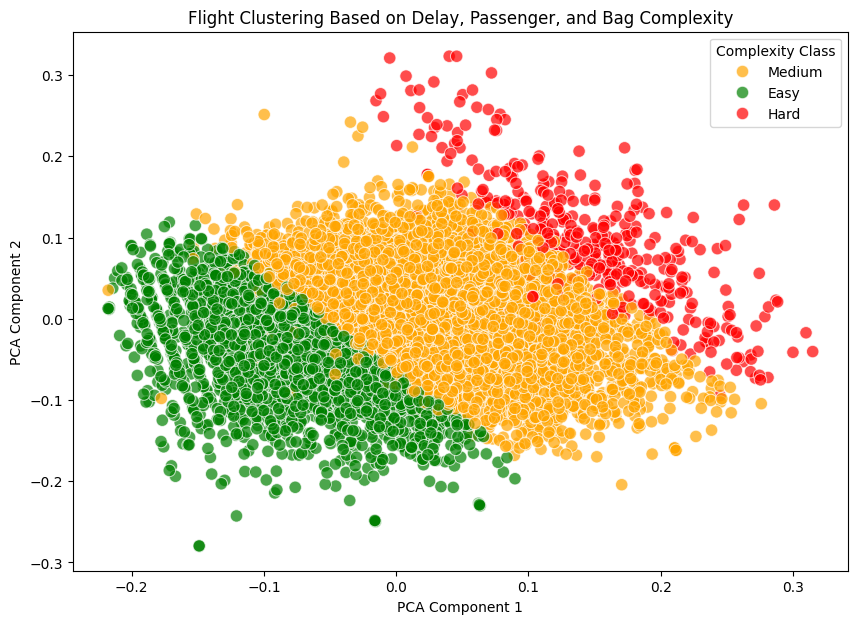

In [51]:

# Features for clustering
features = ['delay_complexity_score', 'passenger_complexity_score', 'bag_complexity_score']
X = merged_df[features]

# Apply PCA to reduce to 2D for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Add PCA components to dataframe
merged_df['pca1'] = X_pca[:,0]
merged_df['pca2'] = X_pca[:,1]

# Plot
plt.figure(figsize=(10,7))
sns.scatterplot(
    data=merged_df,
    x='pca1',
    y='pca2',
    hue='complexity_class',
    palette={'Easy':'green','Medium':'orange','Hard':'red'},
    alpha=0.7,
    s=80
)
plt.title('Flight Clustering Based on Delay, Passenger, and Bag Complexity')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title='Complexity Class')
plt.show()
